<a href="https://colab.research.google.com/github/Rodisolomon/23_spring_course/blob/main/ml_large_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pre

load data, separate into vali, test, and train set. Also load numpy arrays into dataset using TensorDataset for easier training

In [ ]:
import os
import time
import pylab as py
import torch
import numpy as np

# Torch functions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Utility to track progress of a routine.
#from tqdm import tqdm
from tqdm.notebook import trange, tqdm
from google.colab import drive
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader


In [ ]:
import os
# Check if you're on Google drive or on your own machine.
# Get path to your data.
if ('google' in str(get_ipython())):
    from google.colab import drive
    drive.mount('ME')
    #predir='/content/ME/My Drive/'
    predir='ME/My Drive/'
else:
    predir = os.path.join('Users','amit','Google Drive')
    if os.path.isdir(os.path.join(predir,'My Drive')):
            predir=os.path.join(predir,'My Drive')

import torch
import numpy as np

# Torch functions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Utility to track progress of a routine.
#from tqdm import tqdm
from tqdm.notebook import trange, tqdm

# Folder with course data
datadir=predir+'ml_large/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at ME


In [ ]:
def get_mnist():
    data=np.float64(np.load(datadir+'MNIST_data.npy'))
    labels=np.float32(np.load(datadir+'MNIST_labels.npy'))
    print(data.shape)
    data=np.float32(data)/255.
    train_dat=data[0:55000]#.reshape((-1,1,28,28))
    train_labels=np.int32(labels[0:55000])
    val_dat=data[55000:60000]#.reshape((-1,1,28,28))
    val_labels=np.int32(labels[55000:60000])
    test_dat=data[60000:70000]#.reshape((-1,1,28,28))
    test_labels=np.int32(labels[60000:70000])
    comb_ds = data[:60000]
    comb_label = np.int32(labels[:60000])

    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels), (comb_ds, comb_label)

(X_train, y_train), (X_val, y_val), (X_test, y_test), (X_comb, y_comb) = get_mnist()
train_ds = TensorDataset(torch.Tensor(X_train), torch.LongTensor(y_train))
test_ds = TensorDataset(torch.Tensor(X_test), torch.LongTensor(y_test))
val_ds = TensorDataset(torch.Tensor(X_val), torch.LongTensor(y_val))
comb_ds = TensorDataset(torch.Tensor(X_comb), torch.LongTensor(y_comb))

print("Training set: ", X_train.shape, y_train.shape)
print("Validation set: ", X_val.shape, y_val.shape)
print("Combined set: ", X_comb.shape, y_comb.shape)
print("Test set: ", X_test.shape, y_test.shape)

(70000, 784)
Training set:  (55000, 784) (55000,)
Validation set:  (5000, 784) (5000,)
Combined set:  (60000, 784) (60000,)
Test set:  (10000, 784) (10000,)


# a

I choose h_dim = 200, z_dim = 20, input_dim = 784, learning_rate = .001, batch_size = 1000, epoch = 20 as the default setting.

In [ ]:
class VAE(nn.Module): #the VAE architecture
  def __init__(self, input_dim, hidden_dim, z_dim):
    super().__init__()
    self.im_hid = nn.Linear(input_dim, hidden_dim)
    self.hid_mu = nn.Linear(hidden_dim, z_dim)
    self.hid_sig = nn.Linear(hidden_dim, z_dim)

    self.z_hid = nn.Linear(z_dim, hidden_dim)
    self.hid_im = nn.Linear(hidden_dim, input_dim)

  def encode(self, x):
    h = F.relu(self.im_hid(x))
    mu, sig = self.hid_mu(h), self.hid_sig(h)
    return mu, sig

  def decode(self, z):
    h = F.relu(self.z_hid(z))
    img = F.sigmoid(self.hid_im(h))
    return img

  def forward(self, x):
    mu, sig = self.encode(x)
    eps = torch.randn_like(sig)
    new_z = mu + eps*sig
    new_x = self.decode(new_z)
    return new_x, mu, sig

def VAE_loss(X, re_X, mu, sig):
  return nn.BCELoss(reduction = 'sum')(re_X.view(-1, 784), X.view(-1, 784))  -   0.5 * torch.sum(1 + torch.log(sig**2) - mu**2 - sig**2)


def VAE_train(train_ds, test_ds, vali_ds, p = True, h_dim = 200, z_dim = 20, input_dim = 784, learning_rate = .001, batch_size = 1000, epoch = 20, shuffle = True):
  tr_loss, vali_loss  = [], []
  model = VAE(input_dim, h_dim, z_dim).to(device)
  optimizer = optim.Adam(model.parameters(), lr = learning_rate)
  train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
  test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
  val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

  if p:
    print("start training...")

  for i in range(epoch):
    train_loss = 0
    for x, y in train_loader:
      optimizer.zero_grad()
      new_x, mu, sig = model(x)
      loss = VAE_loss(x, new_x, mu, sig)
      loss.backward()
      train_loss += loss.item()
      optimizer.step()
    new_trl = train_loss/len(train_loader.dataset)
    tr_loss.append(new_trl)

    model.eval()
    new_vl = 0
    with torch.no_grad():
        for x, y in val_loader:
            new_x, mu, log_var = model(x)
            loss = VAE_loss(x, new_x, mu, log_var)
            new_vl += loss.item()
    new_vl /= len(val_loader.dataset)
    vali_loss.append(new_vl)
    if p:
      print('Training set epoch {}: Avg. train loss: {:.4f}, Avg. validation loss: {:.4f}'.format(i,
    new_trl, new_vl))


  if not os.path.isdir(os.path.join(datadir,'tmp')):
    os.mkdir(os.path.join(datadir,'tmp'))
  torch.save(model.state_dict(), f'{datadir}final_model.pth')
  return model, tr_loss, vali_loss




In [ ]:
h_dim = 200
z_dim = 10
input_dim = 784

In [ ]:

VAE_train(train_ds, test_ds, val_ds, h_dim = h_dim, z_dim = z_dim, input_dim = input_dim)

start training...
Training set epoch 0: Avg. train loss: 304.3288, Avg. validation loss: 225.5858
Training set epoch 1: Avg. train loss: 210.7421, Avg. validation loss: 201.8907
Training set epoch 2: Avg. train loss: 184.2635, Avg. validation loss: 172.3832
Training set epoch 3: Avg. train loss: 161.6661, Avg. validation loss: 153.7614
Training set epoch 4: Avg. train loss: 148.5403, Avg. validation loss: 144.5235
Training set epoch 5: Avg. train loss: 142.0430, Avg. validation loss: 139.1942
Training set epoch 6: Avg. train loss: 137.4750, Avg. validation loss: 135.0347
Training set epoch 7: Avg. train loss: 134.0049, Avg. validation loss: 131.9169
Training set epoch 8: Avg. train loss: 131.4586, Avg. validation loss: 129.7313
Training set epoch 9: Avg. train loss: 129.5712, Avg. validation loss: 127.9621
Training set epoch 10: Avg. train loss: 127.9785, Avg. validation loss: 126.5389
Training set epoch 11: Avg. train loss: 126.6642, Avg. validation loss: 125.3196
Training set epoch 1

(VAE(
   (im_hid): Linear(in_features=784, out_features=200, bias=True)
   (hid_mu): Linear(in_features=200, out_features=10, bias=True)
   (hid_sig): Linear(in_features=200, out_features=10, bias=True)
   (z_hid): Linear(in_features=10, out_features=200, bias=True)
   (hid_im): Linear(in_features=200, out_features=784, bias=True)
 ),
 [304.32877244318183,
  210.74213579545454,
  184.26348977272727,
  161.66610227272727,
  148.54030085227274,
  142.04301164772727,
  137.47497329545453,
  134.00488096590908,
  131.4586328125,
  129.57118792613636,
  127.97846803977272,
  126.66419772727272,
  125.53225894886364,
  124.55528579545455,
  123.6796309659091,
  122.90085255681818,
  122.22435298295454,
  121.58609630681818,
  121.00332230113636,
  120.49735440340909],
 [225.585834375,
  201.89066875,
  172.38315625,
  153.761434375,
  144.523459375,
  139.194190625,
  135.0347,
  131.91685,
  129.731325,
  127.96209375,
  126.5388859375,
  125.31960625,
  124.1870171875,
  123.07908125,
  12

# b

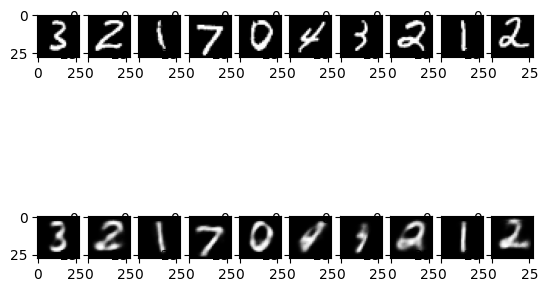

In [ ]:
model = VAE(input_dim, h_dim, z_dim).to(device)
model.load_state_dict(torch.load(f'{datadir}final_model.pth'))
model.eval()

test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)
fig, ax = plt.subplots(2, 10)
for i, (x, y) in enumerate(test_loader):
  if i == 10:
    break
  x_re, mu, log_var = model(x) #encode and then decode
  x, x_re = x.reshape(-1, 28, 28), x_re.detach().reshape(-1, 28, 28)
  ax[0][i].imshow(x[i], cmap='gray')
  ax[1][i].imshow(x_re[i], cmap='gray')

plt.show()

#c

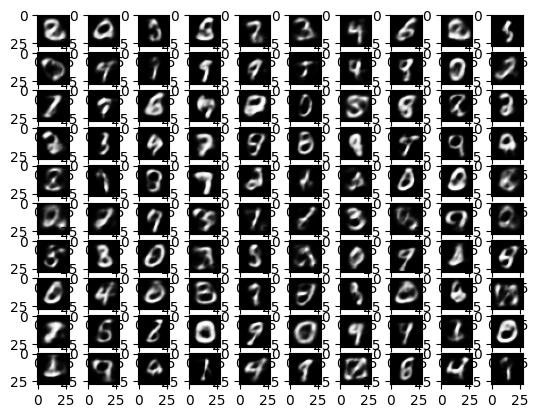

In [ ]:
model.eval()

fig, ax = plt.subplots(10, 10)
for a in range(100):
  x_re = model.decode(torch.randn(1, z_dim)).detach().numpy().reshape(-1, 28, 28) #sample from torch.randn, and then decode
  ax[a//10][a%10].imshow(x_re[0], cmap='gray')

plt.show()

#d

Observation: lower loss corresponding to lower FID score (FID score decrease with validation loss), which means that the re-generated image correlates well with the original data. when hidden dimension = 1024 and z dimension = 20 the validation loss is the lowest.

In [ ]:
import scipy #refer to https://www.kaggle.com/code/ibtesama/gan-in-pytorch-with-fid
def fid_score(mu, mu_w, sig, sig_w):
  eps=1e-6
  dif = np.power(np.linalg.norm(mu-mu_w),  2)
  covmean = scipy.linalg.sqrtm(sig).dot(sig_w).dot(scipy.linalg.sqrtm(sig))
  covmean = scipy.linalg.sqrtm(covmean)
  tr = (sig + sig_w - 2*covmean).real
  return dif + np.trace(tr)

In [ ]:
#differerent hidden dimension and encoded dimension
hs = [256, 512, 1024]
zs = [10, 20, 40]

#train and test
for h in hs:
  for z in zs:
    model, tr_loss, vali_loss = VAE_train(train_ds, test_ds, val_ds, p = False, h_dim = h, z_dim = z, input_dim = 784, epoch = 10)
    model.eval()

    x_re = model.decode(torch.randn(2000, z)).detach().numpy()
    mu = np.mean(x_re, axis=0)
    sig = np.cov(x_re, rowvar=False)

    mu_w = np.mean(X_train, axis=0)
    sig_w = np.cov(X_train, rowvar=False)

    f = fid_score(mu, mu_w, sig, sig_w)
    print(f"we test with hidden dimension = {h} and z dimension = {z}, validation loss is {vali_loss[-1]}, FID score = {f}")



we test with hidden dimension = 256 and z dimension = 10, validation loss is 126.0188609375, FID score = 15.593963104664775
we test with hidden dimension = 256 and z dimension = 20, validation loss is 124.3275125, FID score = 13.54773647702656
we test with hidden dimension = 256 and z dimension = 40, validation loss is 132.8752125, FID score = 16.329977794367277
we test with hidden dimension = 512 and z dimension = 10, validation loss is 121.3624671875, FID score = 13.585794018650667
we test with hidden dimension = 512 and z dimension = 20, validation loss is 117.303425, FID score = 11.500073501041358
we test with hidden dimension = 512 and z dimension = 40, validation loss is 121.7929390625, FID score = 12.742912348626515
we test with hidden dimension = 1024 and z dimension = 10, validation loss is 115.88844375, FID score = 12.538599894679631
we test with hidden dimension = 1024 and z dimension = 20, validation loss is 111.054375, FID score = 9.256006843950733
we test with hidden dime

#f

Observation: -Q will decrease as k increase and seems to converge and approach $log P(x)$ which is the lowerbound

$\lim_{{k \to \infty}} E_{q(z \mid x)}[\log \frac{p(x,z)}{q(z | x)}] = log P(x)$


In [ ]:
def Q(model, x, k, mu, sig):
  mu_ext = mu.unsqueeze(1).repeat(1,k,1)
  sig = torch.abs(sig.unsqueeze(1).repeat(1,k,1))
  eps_ext = torch.randn_like(sig)
  z_ext = mu_ext + sig * eps_ext
  x_re = model.decode(z_ext)
  x_ext = x.unsqueeze(1).repeat(1,k,1)

  log_bce = - nn.BCELoss(reduction='none')(x_re, x_ext).sum(axis=2) #numerator, gives negative log likelihood, so need a negative sign ahead
  log_gaussian = torch.sum( torch.log(1/sig)  (z_ext - mu_ext).pow(2) / sig.pow(2) , axis=2) #denominator: gaussian

  ret = log_bce - log_gaussian - torch.log(torch.tensor([k])) #transfer from division and multiplication to +- by converting to log in advanced

  Q_k = torch.logsumexp(ret, dim=1)
  Q_k_avg = torch.mean(Q_k)
  return Q_k, Q_k_avg


In [ ]:
  h, z = 1024, 20
  model, tr_loss, vali_loss = VAE_train(train_ds, test_ds, val_ds, p = False, h_dim = h, z_dim = z, input_dim = 784, epoch = 20)



In [ ]:
ks = [10, 50, 100, 1000]
qks = []
model.eval()
val_loader = DataLoader(val_ds, batch_size=1000, shuffle=False)
data_iter = iter(val_loader)
x_val, y_val = next(data_iter)
mu, sig = model.encode(x_val)
for k in ks:
  Q_k, Q_k_avg = Q(model, x_val, k, mu, sig)
  qks.append(Q_k_avg.item())
  #print(Q_k_avg.item())


Text(0, 0.5, '-Q')

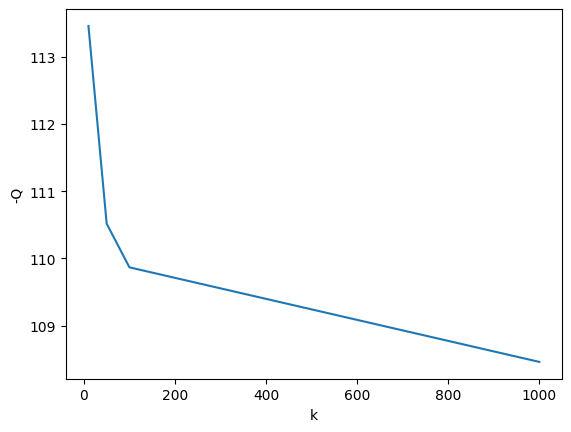

In [ ]:
plt.plot(ks, -np.array(qks))
plt.xlabel("k")
plt.ylabel("-Q")

# g (SVM)

comparing to the raw data, the classification on embedding data has slightly smaller accuracy rate, which might be caused by the loss of details through embedding.

In [ ]:
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate a synthetic classification dataset

def SVC_train(X_train, y_train, X_vali, y_vali, emb=False):
  # Create an SVC classifier
  classifier = svm.SVC()

  # Fit the classifier to the training data
  classifier.fit(X_train, y_train)

  # Predict labels for the test set
  y_pred = classifier.predict(X_vali)

  # Calculate accuracy
  accuracy = accuracy_score(y_vali, y_pred)
  if emb:
    print("Accuracy:", 1 - accuracy)
  else:
    print("Accuracy:", accuracy)
  return accuracy

In [ ]:
#original data without encoding
SVC_train(X_train, y_train, X_val, y_val)

Accuracy: 0.9876


## different size of hidden layer and architecture

How representative is the embedding also affect the accuracy greatly: with better model (eg. what we concluded with dimension = 1024 and z dimension = 20), the accuracy score also is much higher

In [ ]:
#with encoding

hs = [256, 512, 1024] #differnet size of hidden layer and architecture
zs = [10, 20, 40]

#train and test
for h in hs:
  for z in zs:
    model, tr_loss, vali_loss = VAE_train(train_ds, test_ds, val_ds, p = False, h_dim = h, z_dim = z, input_dim = 784, epoch = 10, shuffle=False)
    model.eval()
    train_loader = DataLoader(train_ds, batch_size=1000, shuffle=False)
    arr = []
    for x, y in train_loader:
      emb = torch.cat(model.encode(x), dim=1)
      arr.append(emb)
    encoded_X_train = torch.cat(arr, dim=0)

    val_loader = DataLoader(val_ds, batch_size=1000, shuffle=False)
    arr = []
    for x, y in val_loader:
      emb = torch.cat(model.encode(x), dim=1)
      arr.append(emb)
    encoded_X_val = torch.cat(arr, dim=0)

    print(f"for model of hidden dimension = {h} and z dimension = {z}...")
    SVC_train(encoded_X_train.detach().numpy(), y_train, encoded_X_val.detach().numpy(), y_val, False)



for model of hidden dimension = 256 and z dimension = 10...
Accuracy: 0.965
for model of hidden dimension = 256 and z dimension = 20...
Accuracy: 0.9764
for model of hidden dimension = 256 and z dimension = 40...
Accuracy: 0.9756
for model of hidden dimension = 512 and z dimension = 10...
Accuracy: 0.9636
for model of hidden dimension = 512 and z dimension = 20...
Accuracy: 0.9826
for model of hidden dimension = 512 and z dimension = 40...
Accuracy: 0.9842
for model of hidden dimension = 1024 and z dimension = 10...
Accuracy: 0.9682
for model of hidden dimension = 1024 and z dimension = 20...
Accuracy: 0.9862
for model of hidden dimension = 1024 and z dimension = 40...
Accuracy: 0.988


In [ ]:
print(encoded_X_train.detach().numpy().shape, y_train.shape)

(55000, 80) (55000,)


## different training set size
Observation: the accuracy of the final classification increase significantly when training size increases from 0 to about 10000, however, the differernce between 10000 and full size are not that differernt (0.976 vs 0.988)

In [ ]:
# different size of labelled data
acc = []
for i in [100, 1000, 10000, 55000]:
  acc.append(SVC_train(encoded_X_train.detach().numpy()[:i-1], y_train[:i-1], encoded_X_val.detach().numpy(), y_val, False))


Accuracy: 0.7706
Accuracy: 0.9462
Accuracy: 0.976
Accuracy: 0.988


Text(0, 0.5, 'accuracy')

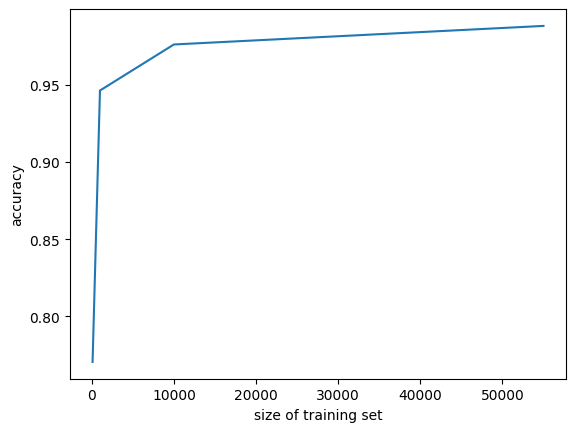

In [ ]:
plt.plot([100, 1000, 10000, 55000], acc)
plt.xlabel("size of training set")
plt.ylabel("accuracy")

# h (generative model)
I use hidden dimension = 1024 and z dimension = 40 (20 will also work)

Observation: k = 100 has slightly better performance than k = 10 but generally there's not that much differernce of the final accuracy rate (comparing between k = 500 and k = 10, the former is supposed to have higher accuracy rate). The training and classification time, though, increases significantly with higher k.

In [ ]:
# train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
# for i, (x, y) in enumerate(train_loader):
#   if i > 1:
#     break
#   print(x.detach().numpy())
#   print(y.item())

In [ ]:
# create 10 dataset
def separate(ds, batch_size): #return 10 dataloader
  dataloader = DataLoader(ds, batch_size=1, shuffle=True)
  dic = {_: [] for _ in range(10)}
  for x, y in dataloader:
    dic[y.item()].append(x.detach().numpy())
  for i in range(10):
    x = np.stack(dic[i])
    y = np.full(len(dic[i]), i)
    ds = TensorDataset(torch.Tensor(x), torch.LongTensor(y))
    class_loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    dic[i] = class_loader
  return dic



In [ ]:
# train and store 10 models
def VAE_train_10(train_ds, vali_ds, p = True, h_dim = 200, z_dim = 20, input_dim = 784, learning_rate = .001, batch_size = 1000, epoch = 20):
  train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
  dic_tr = separate(train_ds, batch_size)
  dic_val = separate(val_ds, batch_size)
  ms = []
  for char in range(10):
    tr_loss, vali_loss  = [], []
    model = VAE(input_dim, h_dim, z_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    if p:
      print(f"start training group {char}...")

    for i in range(epoch):
      train_loss = 0
      for x, y in dic_tr[char]:
        optimizer.zero_grad()
        new_x, mu, sig = model(x)
        loss = VAE_loss(x, new_x, mu, sig)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
      new_trl = train_loss/len(train_loader.dataset)
      tr_loss.append(new_trl)

      model.eval()
      new_vl = 0
      with torch.no_grad():
          for x, y in dic_val[char]:
              new_x, mu, log_var = model(x)
              loss = VAE_loss(x, new_x, mu, log_var)
              new_vl += loss.item()
      new_vl /= len(val_loader.dataset)
      vali_loss.append(new_vl)
      if p:
        print('Training set epoch {}: Avg. train loss: {:.4f}, Avg. validation loss: {:.4f}'.format(i,
      new_trl, new_vl))
    ms.append(model)


    if not os.path.isdir(os.path.join(datadir,'tmp')):
      os.mkdir(os.path.join(datadir,'tmp'))
    torch.save(model.state_dict(), f'{datadir}final_model_{char}.pth')
  return ms




In [ ]:
ms = VAE_train_10(train_ds, val_ds, p = True, h_dim = 1024, z_dim = 40, input_dim = 784, batch_size = 1000, epoch = 20)


start training group 0...
Training set epoch 0: Avg. train loss: 49.7625, Avg. validation loss: 29.5013
Training set epoch 1: Avg. train loss: 27.7313, Avg. validation loss: 26.6937
Training set epoch 2: Avg. train loss: 23.6743, Avg. validation loss: 23.0626
Training set epoch 3: Avg. train loss: 21.8367, Avg. validation loss: 22.0331
Training set epoch 4: Avg. train loss: 21.0251, Avg. validation loss: 21.1028
Training set epoch 5: Avg. train loss: 20.0750, Avg. validation loss: 20.4459
Training set epoch 6: Avg. train loss: 19.2153, Avg. validation loss: 19.6076
Training set epoch 7: Avg. train loss: 18.4951, Avg. validation loss: 18.9574
Training set epoch 8: Avg. train loss: 17.8357, Avg. validation loss: 18.2725
Training set epoch 9: Avg. train loss: 17.1770, Avg. validation loss: 17.7881
Training set epoch 10: Avg. train loss: 16.8332, Avg. validation loss: 17.3732
Training set epoch 11: Avg. train loss: 16.4905, Avg. validation loss: 17.0241
Training set epoch 12: Avg. train lo

In [ ]:
# load trained model
h_dim = 1024
z_dim = 40
input_dim = 784
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)

dic = []
for i in range(10):
  model = VAE(input_dim, h_dim, z_dim).to(device)
  dic.append(model.load_state_dict(torch.load(f'{datadir}final_model_{i}.pth')))

In [ ]:
#classify with largest Q
def test(ms):
  with torch.no_grad():
    for k in [10, 100]:
      print(f"========= test model with k = {k} =========")
      maxss = []
      for j, (x,y) in enumerate(test_loader): #batch = 1000
        correct = 0
        qs = []
        for i in range(10):
          m = ms[i]
          m.eval()
          mu, sig = m.encode(x)
          Q_k, Q_k_avg = Q(m, x, k, mu, sig)
          qs.append(Q_k)
        Q_stack = torch.stack(qs, dim=1)
        pred = torch.argmax(Q_stack, dim=1) #take the class with largest Q value
        correct = np.sum(pred.detach().numpy() == y.detach().numpy())
        print(f"for batch {j}, the accuracy rate is {correct/1000}")


In [ ]:
test(ms) #I test directly with k=500 for supposedly more significant difference

========= test model with k = 10 =========
for batch 0, the accuracy rate is 0.933
for batch 1, the accuracy rate is 0.961
for batch 2, the accuracy rate is 0.935
for batch 3, the accuracy rate is 0.927
for batch 4, the accuracy rate is 0.945
for batch 5, the accuracy rate is 0.962
for batch 6, the accuracy rate is 0.957
for batch 7, the accuracy rate is 0.939
for batch 8, the accuracy rate is 0.963
for batch 9, the accuracy rate is 0.954
========= test model with k = 500 =========
for batch 0, the accuracy rate is 0.941
for batch 1, the accuracy rate is 0.958
for batch 2, the accuracy rate is 0.934
for batch 3, the accuracy rate is 0.934
for batch 4, the accuracy rate is 0.951
for batch 5, the accuracy rate is 0.96
for batch 6, the accuracy rate is 0.96
for batch 7, the accuracy rate is 0.942
for batch 8, the accuracy rate is 0.967
for batch 9, the accuracy rate is 0.958


## train with combined dataset and validate with test dataset
Observation: Similar to the training vs validation, if we use all validation+training data to train and test with test ds, k = 100 has slightly better performance than k = 10.


In [ ]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), (X_comb, y_comb) = get_mnist()
train_ds = TensorDataset(torch.Tensor(X_train), torch.LongTensor(y_train))
test_ds = TensorDataset(torch.Tensor(X_test), torch.LongTensor(y_test))
val_ds = TensorDataset(torch.Tensor(X_val), torch.LongTensor(y_val))
comb_ds = TensorDataset(torch.Tensor(X_comb), torch.LongTensor(y_comb))

print("Training set: ", X_train.shape, y_train.shape)
print("Validation set: ", X_val.shape, y_val.shape)
print("Combined set: ", X_comb.shape, y_comb.shape)
print("Test set: ", X_test.shape, y_test.shape)

(70000, 784)
Training set:  (55000, 784) (55000,)
Validation set:  (5000, 784) (5000,)
Combined set:  (60000, 784) (60000,)
Test set:  (10000, 784) (10000,)


In [ ]:
ms = VAE_train_10(comb_ds, test_ds, p = True, h_dim = 1024, z_dim = 40, input_dim = 784, batch_size = 1000, epoch = 20)


start training group 0...
Training set epoch 0: Avg. train loss: 46.6848, Avg. validation loss: 30.2221
Training set epoch 1: Avg. train loss: 27.7628, Avg. validation loss: 25.9762
Training set epoch 2: Avg. train loss: 23.2187, Avg. validation loss: 22.7103
Training set epoch 3: Avg. train loss: 21.8602, Avg. validation loss: 21.8255
Training set epoch 4: Avg. train loss: 20.9012, Avg. validation loss: 21.0752
Training set epoch 5: Avg. train loss: 20.0378, Avg. validation loss: 20.2541
Training set epoch 6: Avg. train loss: 19.2096, Avg. validation loss: 19.4142
Training set epoch 7: Avg. train loss: 18.4966, Avg. validation loss: 18.6923
Training set epoch 8: Avg. train loss: 17.7673, Avg. validation loss: 18.0561
Training set epoch 9: Avg. train loss: 17.2303, Avg. validation loss: 17.7105
Training set epoch 10: Avg. train loss: 16.8631, Avg. validation loss: 17.2962
Training set epoch 11: Avg. train loss: 16.5942, Avg. validation loss: 17.0923
Training set epoch 12: Avg. train lo

In [ ]:
test(ms)

========= test model with k = 10 =========
for batch 0, the accuracy rate is 0.939
for batch 1, the accuracy rate is 0.961
for batch 2, the accuracy rate is 0.934
for batch 3, the accuracy rate is 0.943
for batch 4, the accuracy rate is 0.952
for batch 5, the accuracy rate is 0.963
for batch 6, the accuracy rate is 0.957
for batch 7, the accuracy rate is 0.948
for batch 8, the accuracy rate is 0.965
for batch 9, the accuracy rate is 0.965
========= test model with k = 100 =========
for batch 0, the accuracy rate is 0.936
for batch 1, the accuracy rate is 0.963
for batch 2, the accuracy rate is 0.937
for batch 3, the accuracy rate is 0.943
for batch 4, the accuracy rate is 0.956
for batch 5, the accuracy rate is 0.962
for batch 6, the accuracy rate is 0.966
for batch 7, the accuracy rate is 0.956
for batch 8, the accuracy rate is 0.967
for batch 9, the accuracy rate is 0.966
